## Social graphs & intercations
- Assignment 1
- Submission date: September 30th 2025

### Group 101
- Aryan Mirzazadeh - s204489
- Juan Manuel Rodriguez - s253505 
- Vladyslav Horbatenko - s254355

# Formalia: (Delete before hand-in)

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday September 30th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

# Assignment 1.1: Exploring WS and BA models

This first part draws on the Watts-Stogatz and Barabasi-Albert models from Week 3. You should provide solutions to the exercises with the following titles from **Part 1** 

* *Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook*

* *WS edition*

And from **Part 2**

* *BA Edition*.
  * **Note**: The second part of this exercise (after the questions to the text) first has you build a BA network step-by-step, but doesn't ask any questions. For that part, I would simply like you to write well-documented code that shows how you build the network. 


# Assignment 1.2: Stats and visualization of the Rock Music Network

This second part requires you to have built the network of Rock Musicians as described in the exercises for Week 4. You should complete the following exercise from **Part 2**.

* *Explain your process in words*

* *Simple network statistics and analysis*.

  * **Note related to this and the following exercise**. It is nice to have the dataset underlying the statistics and visualization available when we grade. Therefore, I recommend that you create a small *network dataset*, which is simply your graph stored in some format that you like (since it's only a few hundred nodes and a few thousand edges, it won't take up a lot of space). You can then place that network one of your group members' GitHub account (or some other server that's available online) and have your Jupyter Notebook fetch that dataset when it runs. (It's OK to use an LLM for help with setting this up, if it seems difficult). 

And the following exercise from **Part 3**

* *Let's build a simple visualization of the network*

And that's it! You're all set.

### Crawling Exercise
1. Crawl wikipedia list of rock performers and then explain the process
2. How LLMs were used
3. What we would do differently
#### Crawling process
1. Fetched the wiki page content of the list of rock performers by using the same strategy as week 1 exercises.
2. Used a regex pattern (`r"\[{2}([^#\[\]<>{}|_]*)[|#]?[^#\[\]<>{}|_]*\]{2}"`), to match the wikipedia reference formatting to find all of the artists. Afterwards, removed the false positives by creating an `ignore_matches` list to filter out false positives and non band matches. For example: `"Category:", "AllMusic", "rock music"`
3. Fetched the wiki page content of all the artist found in parallel and saved the content in txt files per artist. And loaded the data in a dictionary, ready to be used by `NetworkX`

#### LLMs usage
We used LLMs, when our initial regex pattern was missing a couple of matches, since some of the bands had special characters in their names.

Also, we updated our initial fetching process (per artist), to be async and utilize 100 thread workers simultaneously. This reduced our fetching time from 4 minutes to 4-10 seconds.

#### Crawling alternative choices
First of all, we should have discarded all text before "0-9" heading and after "References" heading when we fetched the list of rock performers. This would have prevented the need to check if the matches are actual bands or not.

Secondly, the the regex pattern could have been more specific, since all artists in the page are displayed in order in markdown format. This means that all exact artists can be found if we matched something like "\* \[\[artist name | (optional extra text)]]". This improvement by itself would have also prevented the need for checking the list for any non-related matches.

In [13]:
# Fetch and load the rock band graph from our GitHub repository
import json
import networkx as nx
import requests
import gzip
import io
import os

local_network = "data/rock_graph_node_link.json.gz"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_network}"
read_graph_kwargs = {"comments": "#", "delimiter": "|", "create_using": nx.DiGraph()}

if os.path.exists(local_network):
    with gzip.open("data/rock_graph_node_link.json.gz", "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
print(
    f"Loaded graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges.",
    f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}",
    sep="\n",
)

Loaded graph with 488 nodes and 7323 edges.
Graph component count: 5


### Network Statistics Exercise

**Network Size & Links**:

The Network has 488 nodes and 7323 links.

However, 4 of those nodes were completely isolated. So, those nodes were removed (seen below) from the network before proceeding with the rest of the statistics.

The removal of isolated nodes, lets the graph to be a one single large component. So there is no need of further extraction.

In [14]:
# Remove isolated nodes from the graph
isolated_nodes = list(nx.isolates(G_bands))
G_bands.remove_nodes_from(isolated_nodes)
print(
    f"Removed {len(isolated_nodes)} isolated nodes.",
    G_bands,
    f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}",
    sep="\n",
)

Removed 4 isolated nodes.
DiGraph with 484 nodes and 7323 edges
Graph component count: 1


#### Degree distribution

Question:
- Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?
- Compare the out-degree distribution to a *random network* with the same number of nodes and links.
- Compare the in-degree distribution to a *scale-free* network with the same number of nodes.

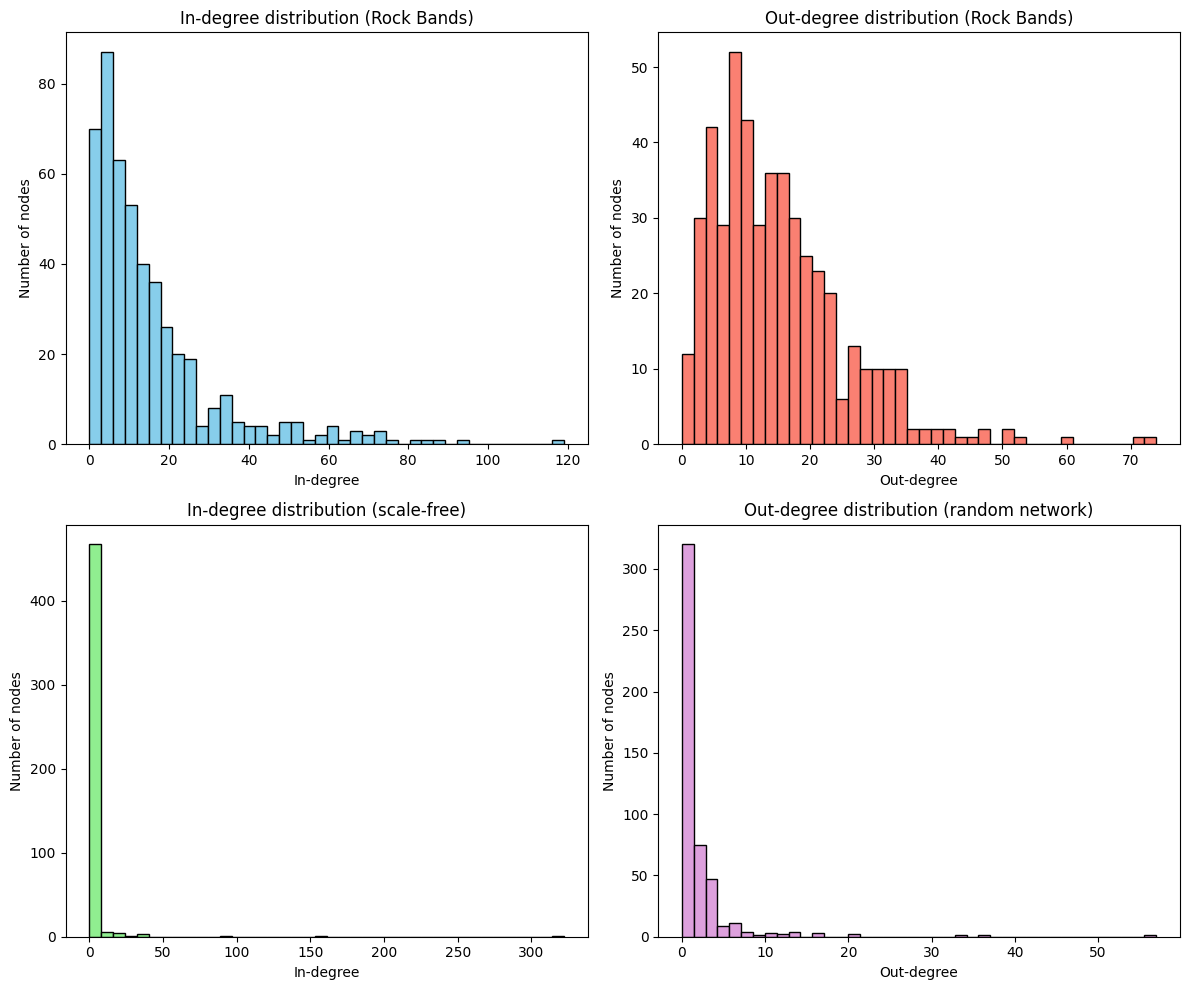

In [26]:
# Network Degree distribution (2x2: top row = G_bands in/out, bottom row = scale-free in/out)
import matplotlib.pyplot as plt

bins = 40
y_axis_label = "Number of nodes"
in_degrees = dict(G_bands.in_degree())
out_degrees = dict(G_bands.out_degree())

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].hist(
    list(in_degrees.values()), bins=bins, color="skyblue", edgecolor="black"
)
axes[0, 0].set_title("In-degree distribution (Rock Bands)")
axes[0, 0].set_xlabel("In-degree")
axes[0, 0].set_ylabel(y_axis_label)

axes[0, 1].hist(
    list(out_degrees.values()), bins=bins, color="salmon", edgecolor="black"
)
axes[0, 1].set_title("Out-degree distribution (Rock Bands)")
axes[0, 1].set_xlabel("Out-degree")
axes[0, 1].set_ylabel(y_axis_label)

sf = nx.scale_free_graph(G_bands.number_of_nodes(), seed=42)
sf_in = dict(sf.in_degree())

axes[1, 0].hist(list(sf_in.values()), bins=bins, color="lightgreen", edgecolor="black")
axes[1, 0].set_title("In-degree distribution (scale-free)")
axes[1, 0].set_xlabel("In-degree")
axes[1, 0].set_ylabel(y_axis_label)

rn = nx.gnm_random_graph(G_bands.number_of_nodes(), G_bands.number_of_edges(), seed=42)
rn_out = dict(sf.out_degree())

axes[1, 1].hist(list(rn_out.values()), bins=bins, color="plum", edgecolor="black")
axes[1, 1].set_title("Out-degree distribution (random network)")
axes[1, 1].set_xlabel("Out-degree")
axes[1, 1].set_ylabel(y_axis_label)

plt.tight_layout()
plt.show()


In [16]:
# Top 5 most connected bands (in-degree) and (out-degree)
top5_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
top5_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
# Top 10 bands with the longest wiki entries
top10_entries = sorted(
    [(band, data.get("content_length", 0)) for band, data in G_bands.nodes(data=True)],
    key=lambda x: x[1],
    reverse=True,
)[:10]

print("Top 5 bands by in-degree:")
for i, (band, degree) in enumerate(top5_in, 1):
    print(f"{i}. {band}: {degree}")

print("\nTop 5 bands by out-degree:")
for i, (band, degree) in enumerate(top5_in, 1):
    print(f"{i}. {band}: {degree}")


print("\nTop 10 bands with the longest wiki entries:")
for i, (band, length) in enumerate(top10_entries, 1):
    print(f"{i}. {band}: {length:,} chars")

Top 5 bands by in-degree:
1. Led Zeppelin: 119
2. Bob Dylan: 95
3. Queen (band): 88
4. Metallica: 85
5. David Bowie: 83

Top 5 bands by out-degree:
1. Led Zeppelin: 119
2. Bob Dylan: 95
3. Queen (band): 88
4. Metallica: 85
5. David Bowie: 83

Top 10 bands with the longest wiki entries:
1. Guns N' Roses: 370,245 chars
2. Marilyn Manson (band): 295,602 chars
3. Coldplay: 294,838 chars
4. Queen (band): 285,019 chars
5. The Rolling Stones: 269,857 chars
6. Paul McCartney: 265,210 chars
7. Bob Dylan: 264,174 chars
8. U2: 263,343 chars
9. David Bowie: 261,246 chars
10. Elton John: 256,840 chars


In [17]:
# Convert to undirected graph + basic statistics
G_band_undirected = G_bands.to_undirected()
print(G_band_undirected)

Graph with 484 nodes and 6019 edges


# Graph Visualization (Part 3)

In the code cell below, we have plotted the undirected rock band network using the Spring and Kamada Kawai layouts.

- Node colors are mapped to use the viridis sequntial color schema and dependent based on their content length attribute
- Node sizes are set to be dependent on the their degree

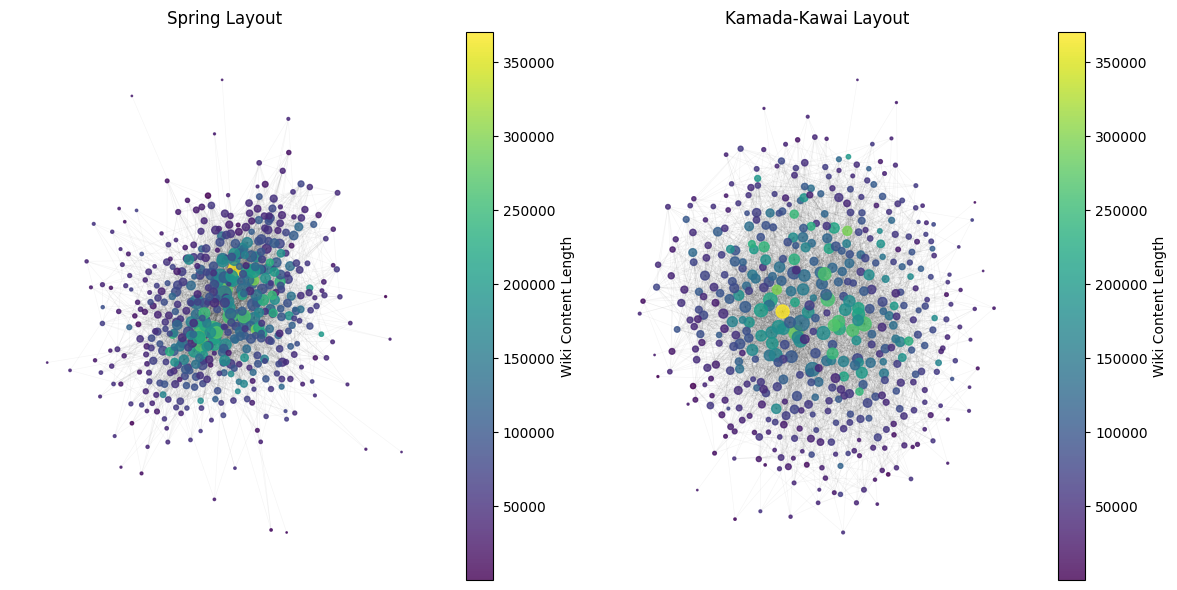

In [19]:
from matplotlib import cm

# Build node size and color arrays from node attributes
degrees = dict(G_band_undirected.degree())
node_sizes = [degrees[n] for n in G_band_undirected.nodes]
content_lengths = [
    G_band_undirected.nodes[n]["content_length"] for n in G_band_undirected.nodes
]

cmap = cm.viridis
nodes_kwargs = {
    "G": G_band_undirected,
    "node_size": node_sizes,
    "node_color": content_lengths,
    "cmap": cmap,
    "alpha": 0.8,
}
edges_kwargs = {
    "G": G_band_undirected,
    "alpha": 0.04,
    "width": 0.5,
}

# Spring Layout graph
plt.figure(figsize=(12, 6))
plt.subplot(121)
pos_spring = nx.spring_layout(G_band_undirected, seed=42)
nodes_spring = nx.draw_networkx_nodes(pos=pos_spring, **nodes_kwargs)
nx.draw_networkx_edges(pos=pos_spring, **edges_kwargs)
plt.title("Spring Layout")
plt.axis("off")
plt.colorbar(nodes_spring, label="Wiki Content Length")
# Kamada-Kawai Layout graph
plt.subplot(122)
pos_kamada = nx.kamada_kawai_layout(G_band_undirected)
nodes_kamada = nx.draw_networkx_nodes(pos=pos_kamada, **nodes_kwargs)
nx.draw_networkx_edges(pos=pos_kamada, **edges_kwargs)
plt.title("Kamada-Kawai Layout")
plt.axis("off")
plt.colorbar(nodes_kamada, label="Wiki Content Length")

plt.tight_layout()
plt.show()

---
### Contributions

- Aryan: Primarily worked on the assignment 1.2
- Juan: Primarily worked on the assignment 1.1
- Vlad: 